## Explainability

In [1]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import sys
import scipy
import itertools
import os
import scipy

warnings.simplefilter('ignore', pd.errors.DtypeWarning)
np.seterr(divide='ignore')
warnings.simplefilter("ignore")

sys.path.append('/sise/home/shakarch/muscle-formation-regeneration')
sys.path.append(os.path.abspath('..'))

from TimeSeriesAnalysis.utils.data_load_save import *
# import TimeSeriesAnalysis.consts as consts
import TimeSeriesAnalysis.params as params
from TimeSeriesAnalysis.auc_over_time_diff_prob import *

In [2]:
import shap
import joblib
shap.initjs()

2023-02-07 16:44:08.801704: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-07 16:44:08.801766: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
def get_cols_list(data):
    cols = list(x_test.columns)
    cols = [re.sub('[^A-Za-z0-9 _]+', '', col) for col in cols]
    cols = [col.replace("Spot position X m", "Spot position X") for col in cols]
    cols = [col.replace("Spot position Y m", "Spot position Y") for col in cols]
    cols.remove("Spot track ID")
    # if "Spot track ID" not in cols:
        # cols.extend(["Spot track ID"])
    # if "Spot frame" not in cols:
        # cols.extend(["Spot frame"])
    return cols

def rename_columns(data):
    data = data.rename(columns=lambda x: re.sub('[^A-Za-z0-9 _]+', '', x))
    # data = data.rename(columns={"Spot position X m": "Spot position X", "Spot position Y m": "Spot position Y",})
    data = data.rename(lambda x: x.replace("Spot position X m", "Spot position X") , axis=1)
    data = data.rename(lambda x: x.replace("Spot position Y m", "Spot position Y") , axis=1)
    return data.loc[:, ~data.columns.duplicated()] # remoe duplicates

In [4]:
def get_explainer(path, save_path=None, palette="Reds_r"):
    clf = joblib.load(path + "/clf.joblib")
    print(clf)
    if isinstance(clf, CalibratedClassifierCV):
        print("calibrated")
        clf = clf.base_estimator
    
    x_test = pd.read_csv(path + "/" + "X_test", encoding="cp1252")
    drop_cols = ["Spot track ID"]
    if "Unnamed: 0" in x_test.columns:
        drop_cols.append("Unnamed: 0")
    
    explainer = shap.explainers.Tree(clf)
    shap_values = explainer.shap_values(x_test.drop(columns=drop_cols))
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(clf.feature_importances_)
    feature_names = np.array(x_test.drop(columns=drop_cols).columns)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    
    n_features = 15
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(data=fi_df.iloc[:n_features], x='feature_importance', y='feature_names',palette=palette)
    #Add chart labels
    plt.title('FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    if save_path:
        plt.savefig(save_path + ".eps", format="eps")
    plt.show()
    
    #plotting the heatmap for correlation
#     important_features = list(fi_df.iloc[:n_features]["feature_names"])
#     sns.heatmap(x_test[important_features].corr(), vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=300), square=True)
#     plt.savefig(save_path + "correlation matrix.eps", format="eps")
#     plt.show()
#     print(important_features)
    return x_test, explainer, shap_values

RandomForestClassifier(max_depth=8)


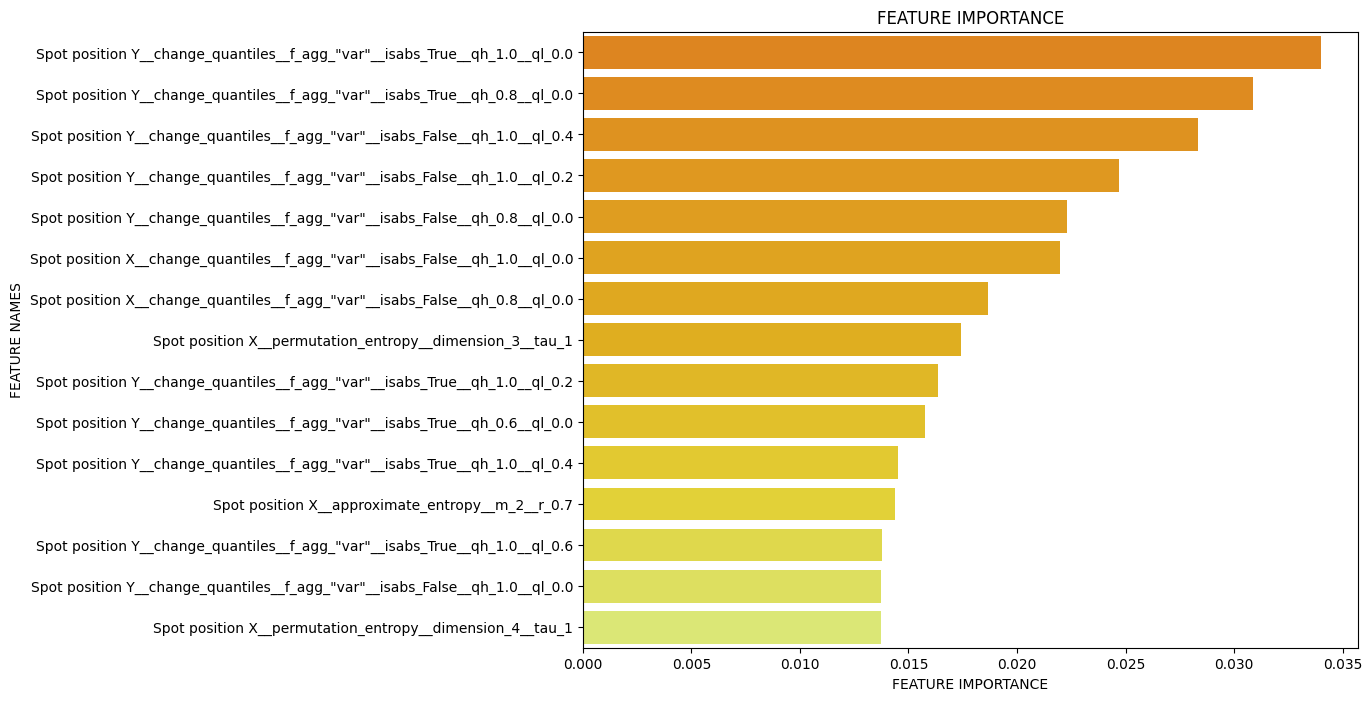

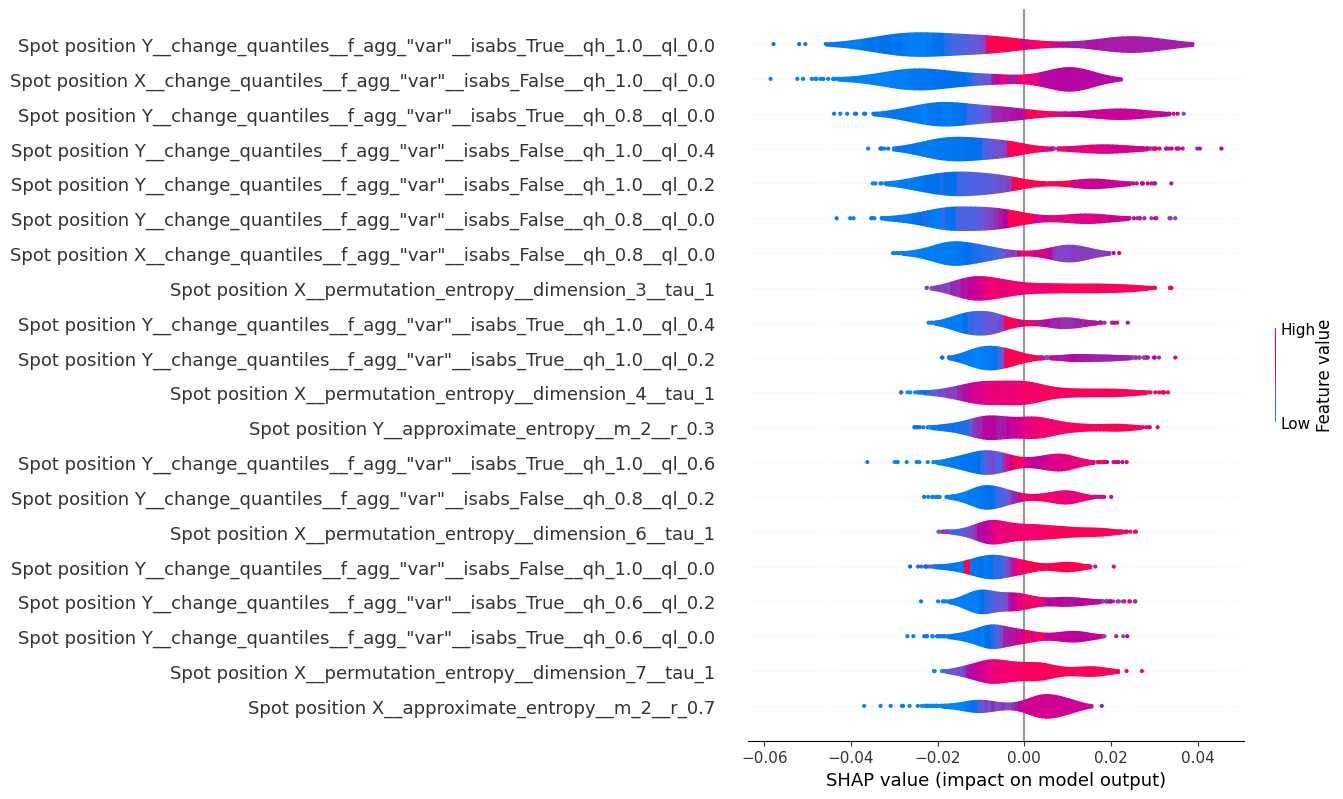

In [27]:
path_mot = consts.motility_model_path % (1, 5)
mot_x_test, mot_explainer, mot_shap_values =get_explainer(path_mot, save_path=consts.storage_path + "eps_figs/feature importance motility", palette="Wistia_r")
shap.summary_plot(mot_shap_values[0], mot_x_test.drop(columns=["Spot track ID"]),  plot_type='violin', show=False)
plt.savefig(consts.storage_path + "eps_figs/shap summary plot motility.eps", format="eps")
plt.show()

RandomForestClassifier(max_depth=8)


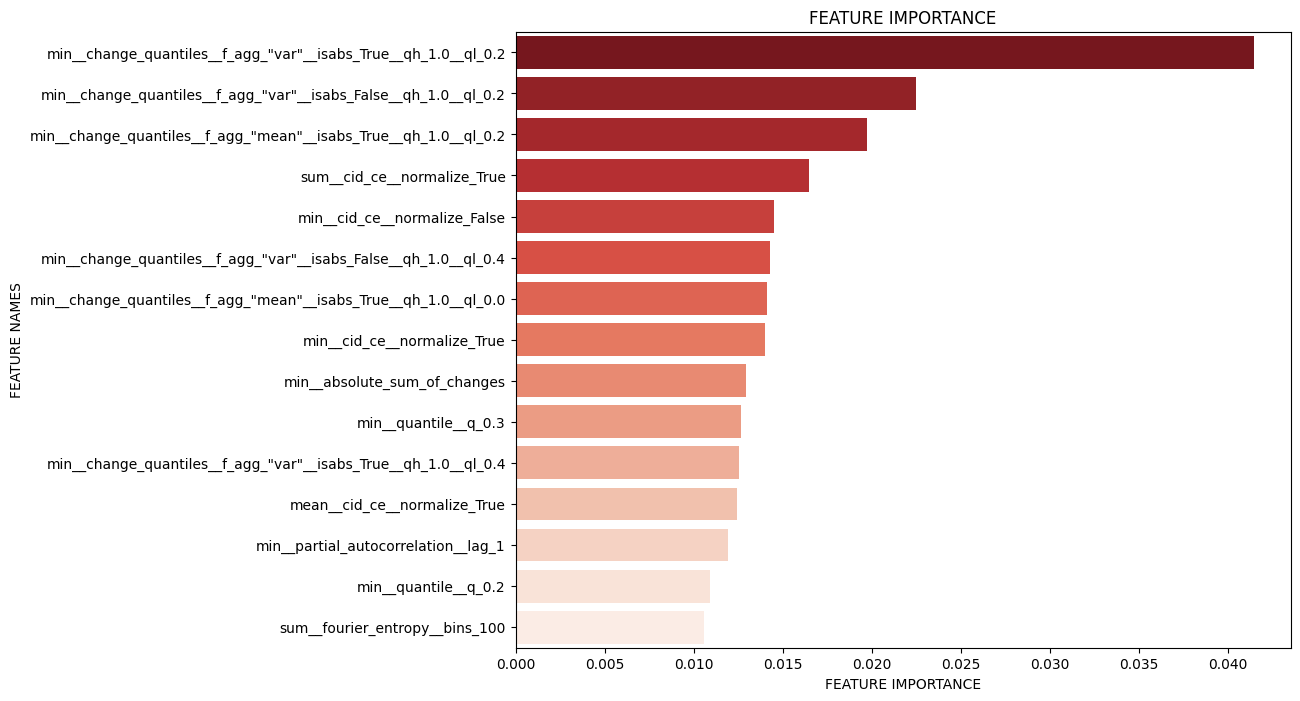

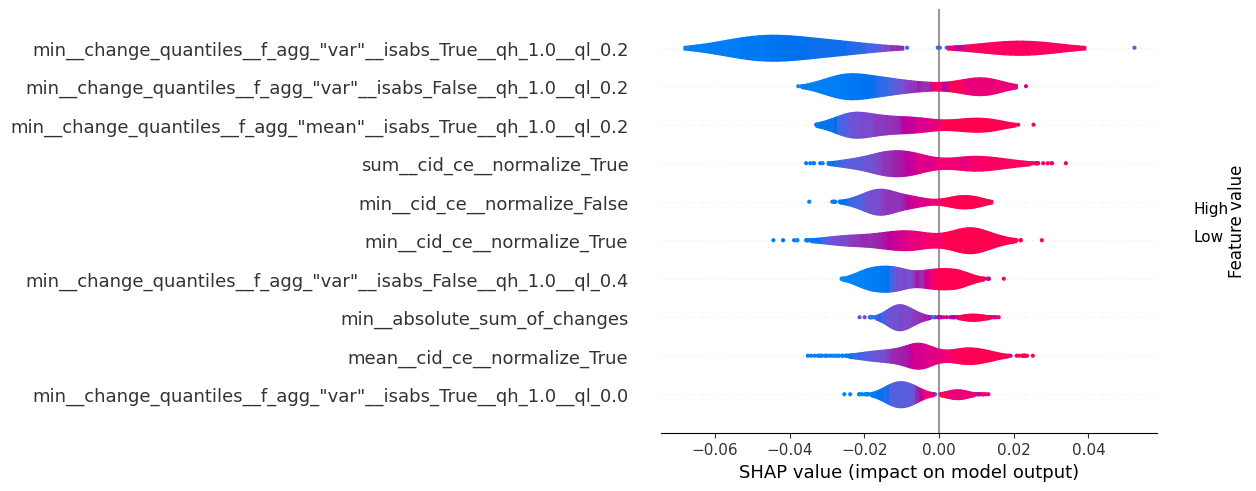

In [28]:
path_int = consts.intensity_model_path % (1, 5)
int_x_test, int_explainer, int_shap_values =get_explainer(path_int, save_path=consts.storage_path + "eps_figs/feature importance intensity", palette="Reds_r")
shap.summary_plot(int_shap_values[0], int_x_test.drop(columns=["Spot track ID"]), max_display=10,  plot_type='violin',show=False)
plt.savefig(consts.storage_path + "eps_figs/shap summary plot intensity.eps", format="eps")
plt.show()

RandomForestClassifier()


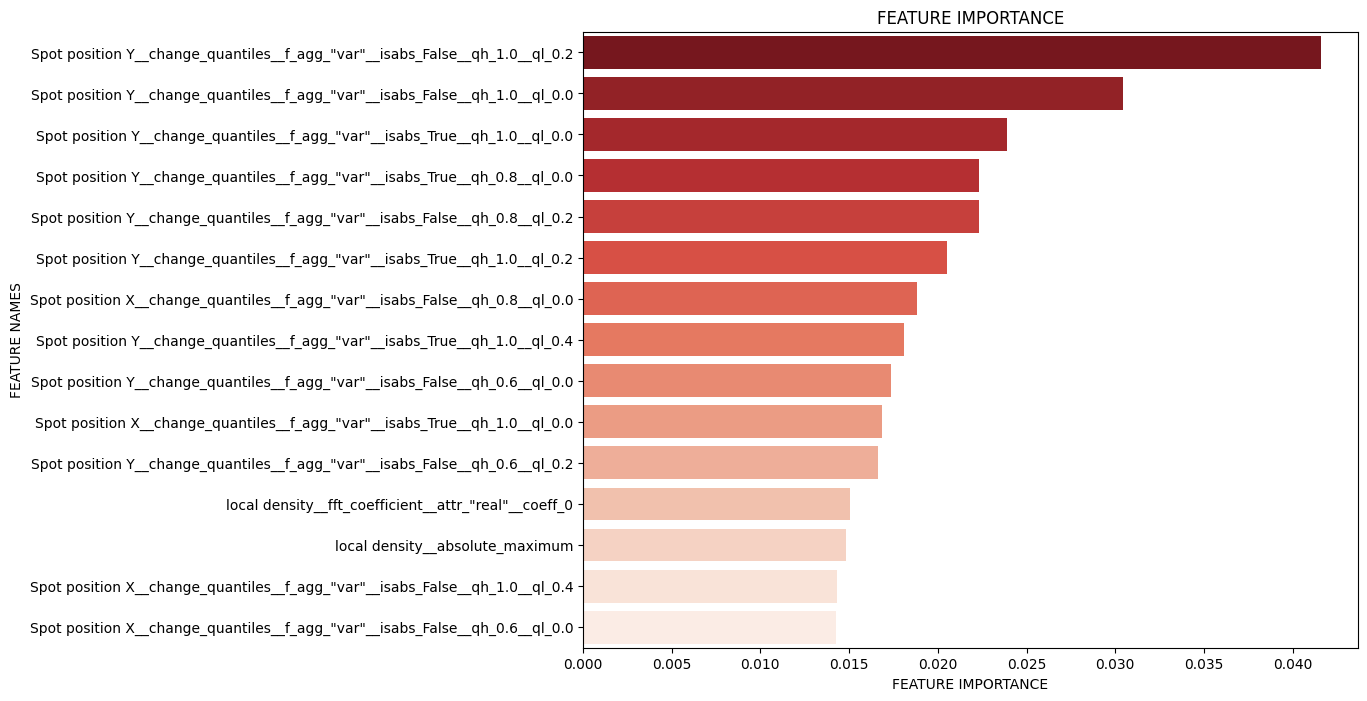

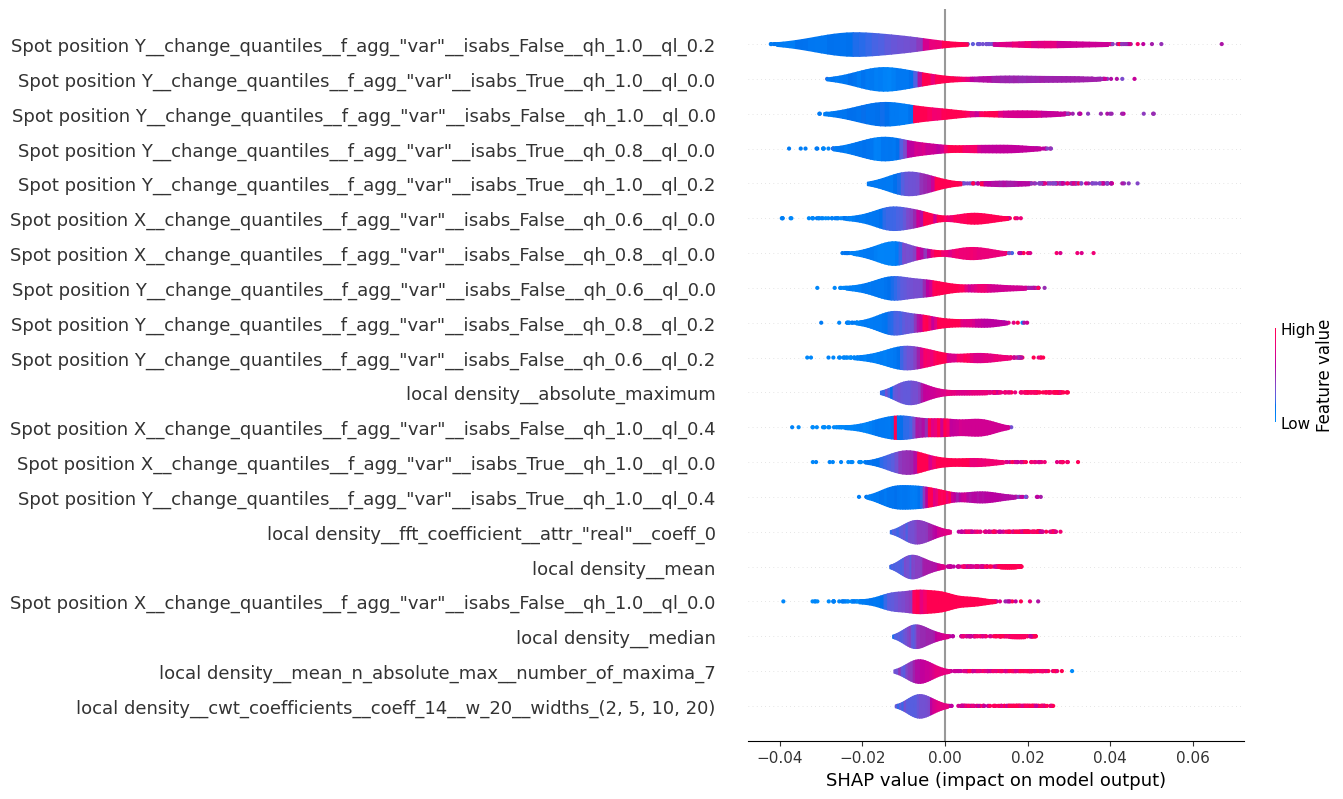

In [27]:
# motility & local density feature importance & shap
path_mot_local_den = "/storage/users/assafzar/Muscle_Differentiation_AvinoamLab/_/_/24-01-2023-motility-local_density local dens-False, s1, s5 train win size 16/track len 30, impute_func-ImputeAllData_impute_zeroes reg MeanOpticalFlowReg_"
mot_local_den_x_test, mot_local_den_explainer, mot_local_den_shap_values =get_explainer(path_mot_local_den)
shap.summary_plot(mot_local_den_shap_values[0], mot_local_den_x_test.drop(columns=["Spot track ID"]),  plot_type='violin')

# counter = 0
# for col in mot_local_den_x_test.columns:
#     if "local density" in col:
#         counter+=1
#         print(col)
# if counter == 0:
#     for col in mot_local_den_x_test.columns:
#         print(col)

RandomForestClassifier()


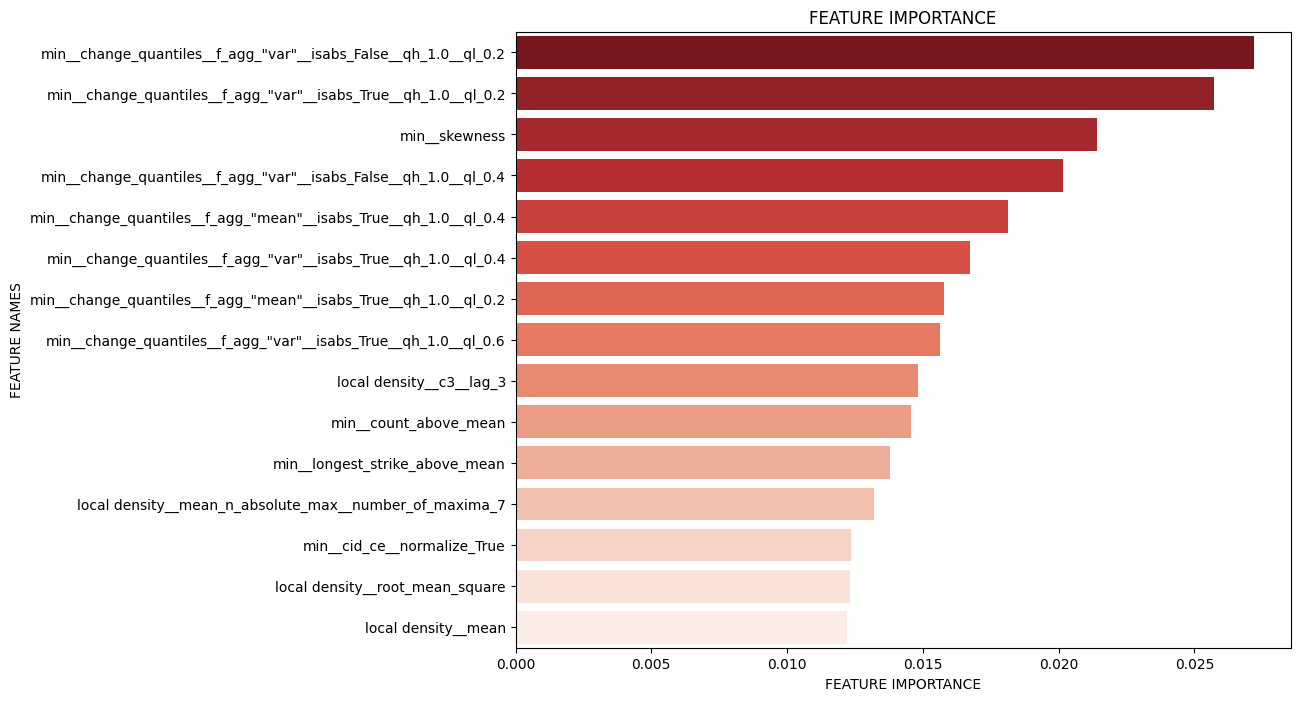

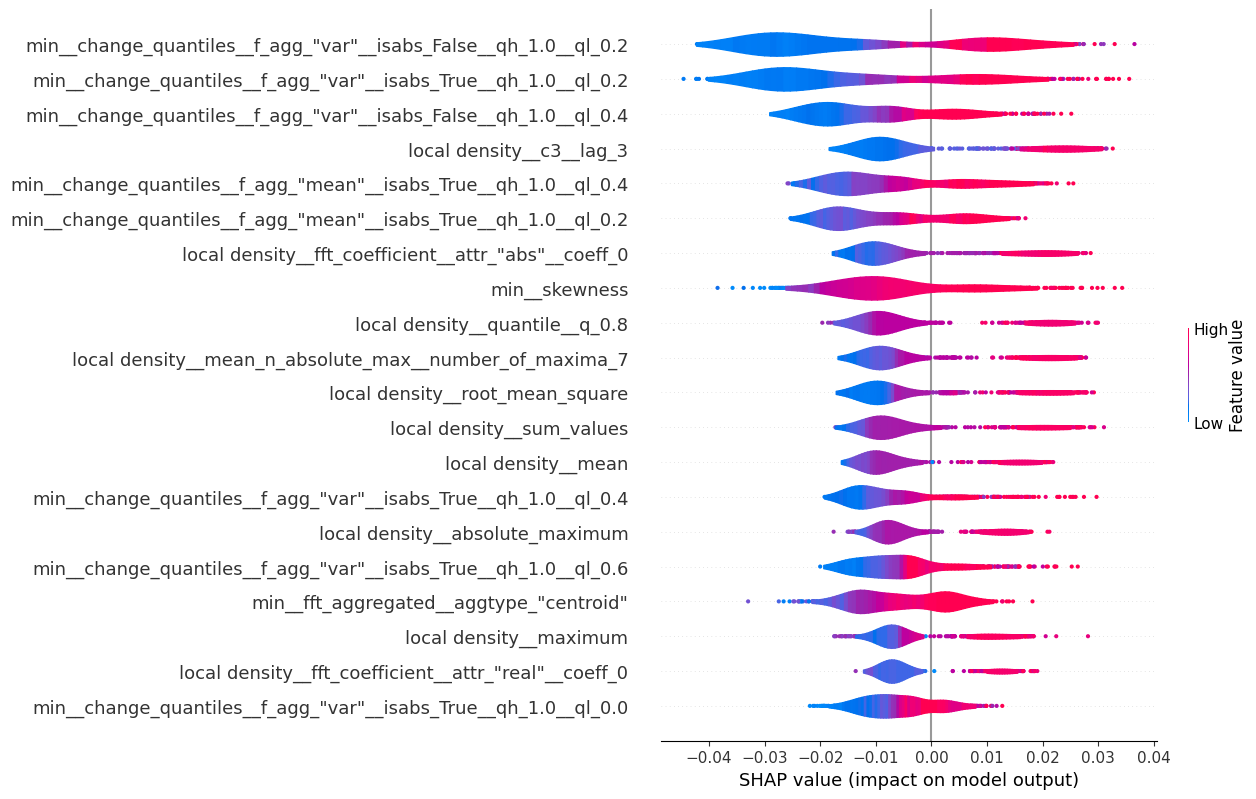

200/535 local density features


In [6]:
# motility & local density feature importance & shap
path_int_local_den = "/storage/users/assafzar/Muscle_Differentiation_AvinoamLab/_/_/06-02-2023-actin_intensity-local_density local dens-False, s1, s5 train win size 16/track len 30, impute_func-ImputeAllData_impute_zeroes reg MeanOpticalFlowReg_"
int_local_den_x_test, int_local_den_explainer, int_local_den_shap_values =get_explainer(path_int_local_den)
shap.summary_plot(int_local_den_shap_values[0], int_local_den_x_test.drop(columns=["Spot track ID"]),  plot_type='violin')

counter = 0
for col in int_local_den_x_test.columns:
    if "local density" in col:
        counter+=1
print(f"{counter}/{len(int_local_den_x_test.columns)} local density features")
        
if counter == 0:
    for col in int_local_den_x_test.columns:
        print(col)

https://github.com/slundberg/shap/issues/837